# Allometry

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as P
import pandas as pd
import glob
import os
import math
import importlib
from sklearn.metrics import r2_score
%matplotlib inline
import seaborn as sns

import amaizeing_utils as maize

## Load model data files

In [3]:
src = '../model/'
model_files = sorted(glob.glob(src+'*.csv'))
model_files

['../model/LPlant.L1_poly_model.csv',
 '../model/LPlant.L2_poly_model.csv',
 '../model/RPlant.L1_poly_model.csv',
 '../model/RPlant.L2_poly_model.csv']

In [45]:
i = 3
csv_file = os.path.normpath(model_files[i]).split(os.path.sep)[-1]
bname = ''.join(csv_file.split('_')[0].split('.'))

data = pd.read_csv(model_files[i])
data = data.set_index('Unnamed: 0')
data.index.rename('idx', inplace=True)

print(bname, data.shape, sep='\t')
data.head()

RPlantL2	(353, 23)


,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,RPlant.L2.End.Angle,RPlant.L2.End.Length,...,A1,N1,A2,N2,a,b,c,d,length,curled
idx,,,,,,,,,,,,,,,,,,,,,
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,75,43.0,...,0.000187,3.480194,-1.219709,1.369629,32.735921,41.534811,35.104978,11.129219,79.220553,0.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,43,46.0,...,0.578393,1.274534,0.000000,0.000000,35.401537,31.371925,54.513587,33.642270,114.470415,1.0
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,85,69.0,...,0.070086,1.710193,-0.041825,1.859051,36.414096,68.737434,32.787400,6.013746,93.843065,0.0
5,MIH119_1006,8,2,1,B37/H95,B37/H95,NaN,1.0,40,72.0,...,0.209486,1.453363,0.000000,0.000000,46.280708,46.280708,55.155200,55.155200,127.988660,1.0
6,MIH119_1007,9,2,1,B37/H95,B73/MO17,NaN,NaN,55,50.0,...,0.004869,2.613210,-1.385162,1.351549,33.841010,40.957602,48.329971,28.678822,84.592126,0.0


Enumerate all the available columns

In [38]:
for i,c in enumerate(data.columns):
    print(i,'\t',c)

0 	 plot
1 	 Pass
2 	 Range
3 	 Rep
4 	 New_Pedigree
5 	 Old_Pedigree
6 	 Old_Source
7 	 Shared
8 	 RPlant.L2.End.Angle
9 	 RPlant.L2.End.Length
10 	 RPlant.L2.Mid.Angle
11 	 RPlant.L2.Mid.Length
12 	 RPlant.L2.Stem.Angle
13 	 A1
14 	 N1
15 	 A2
16 	 N2
17 	 a
18 	 b
19 	 c
20 	 d
21 	 length
22 	 curled


Do an allometry plot and compute the $R^2$ score of the linear fit for every possible combination of parameters

In [46]:
importlib.reload(maize)
trait_s = 8
trait_f = 22
dpi = 100
write_file = False
plot_fig = False
cutoff = 160
dst = '../model/allometry_' + bname + '/'
X, Y, R2 = [], [], []
for i in range(trait_s,trait_f):
    for j in range(i+1, trait_f):
        x,y,r2 = maize.fit_allometry(data, i,j, dpi=dpi, plot_fig=plot_fig,w=write_file, dst=dst)
        R2.append(r2)
        X.append(x)
        Y.append(y)
R2 = np.array(R2)

In [41]:
allometry = pd.DataFrame((X,Y,R2), index=['X','Y','R2']).T
allometry.sort_values(by=['R2'], ascending=False).head()

,X,Y,R2
55,A1,N1,0.928233
70,A2,N2,0.884813
11,RPlant.L1.End.Angle,d,0.651356
21,RPlant.L1.End.Length,b,0.620012
10,RPlant.L1.End.Angle,c,0.598232


Text(0, 0.5, 'R2')

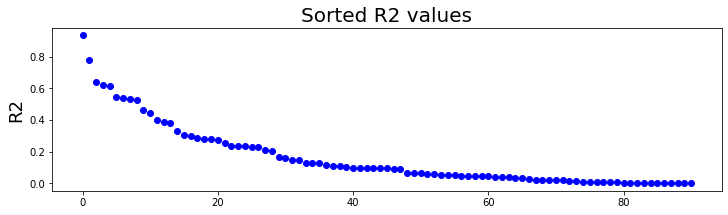

In [47]:
plt.figure(figsize=(12,3))
plt.plot(np.sort(R2)[::-1], 'ob')
plt.title('Sorted R2 values', fontsize=20)
plt.ylabel('R2', fontsize=18)

In [48]:
n = int((1+np.sqrt(1+8*len(R2)))*0.5)
allo_matrix = np.full((n,n), np.nan)
counter = 0
for i in range(n):
    for j in range(i+1,n):
        allo_matrix[i,j] = R2[counter]
        counter += 1

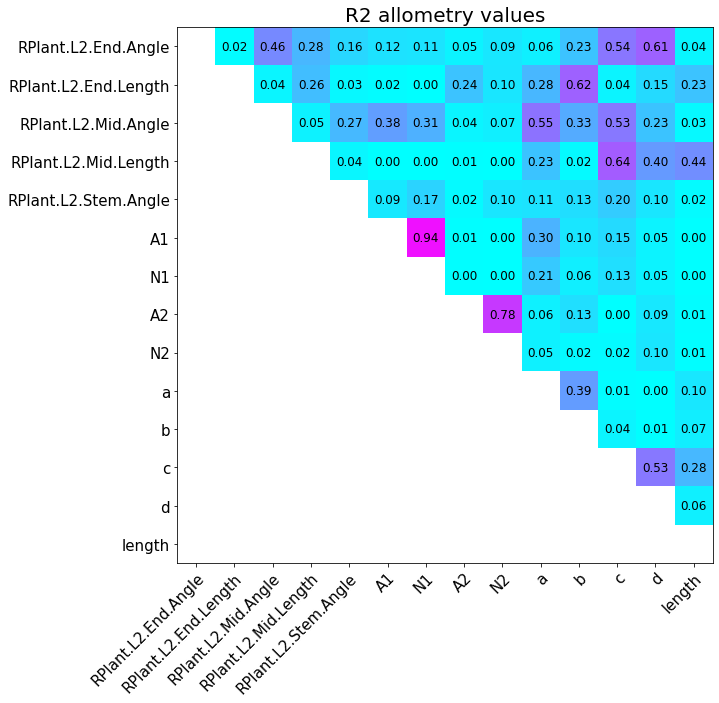

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(allo_matrix, cmap='cool', vmin=0, vmax=1)

# We want to show all ticks...
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
# ... and label them with the respective list entries
ax.set_xticklabels(data.columns[trait_s:trait_f])
ax.set_yticklabels(data.columns[trait_s:trait_f])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.tick_params(labelsize=15)

# Loop over data dimensions and create text annotations.
for i in range(n):
    for j in range(i+1, n):
        text = ax.text(j, i, '{:.2f}'.format(allo_matrix[i, j]),
                       ha="center", va="center", color="black", fontsize=12)

ax.set_title("R2 allometry values", fontsize=20)
fig.tight_layout()

filename = dst + 'allometry_matrix.jpg'
plt.savefig(filename, dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})